In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt

paths = os.listdir('data')

all_data = []

for path in paths:
    with open('data/' + path, 'r') as f:
        data = f.readlines()
    data = [x.strip().split('\t') for x in data]
    all_data.append(data)


In [ ]:
import numpy as np

class SelfOrganizingMap:
    def __init__(self, input_size, map_size, learning_rate=0.1, sigma=1.0):
        self.input_size = input_size
        self.map_height, self.map_width = map_size
        self.initial_learning_rate = learning_rate
        self.initial_sigma = sigma
        
        # Initialize weights randomly
        self.weights = np.random.uniform(
            low=-1.0, 
            high=1.0, 
            size=(self.map_height, self.map_width, input_size)
        )
        
        # Create position matrix for neighborhood calculation
        self.position_matrix = np.array([
            [(i, j) for j in range(self.map_width)]
            for i in range(self.map_height)
        ])
    
    def decay_function(self, initial_value, iteration, max_iter):
        return initial_value * np.exp(-iteration / max_iter)
    
    def calculate_influence(self, winner_pos, current_pos, sigma):
        distance = np.linalg.norm(winner_pos - current_pos)
        return np.exp(-(distance**2) / (2 * sigma**2))
    
    def find_winner(self, x):

        x_reshaped = x.reshape(1, 1, -1)
        distances = np.linalg.norm(self.weights - x_reshaped, axis=2)
        
        winner_idx = np.unravel_index(distances.argmin(), distances.shape)
        return winner_idx
    
    def train(self, data, epochs=100):
    
        n_samples = len(data)
        total_iterations = epochs * n_samples
        
        for epoch in range(epochs):
            np.random.shuffle(data)
            
            for i, x in enumerate(data):
                current_iter = epoch * n_samples + i
                
                learning_rate = self.decay_function(
                    self.initial_learning_rate, 
                    current_iter, 
                    total_iterations
                )
                sigma = self.decay_function(
                    self.initial_sigma, 
                    current_iter, 
                    total_iterations
                )
                
                winner_idx = self.find_winner(x)
                winner_pos = np.array(winner_idx)
                
                for i in range(self.map_height):
                    for j in range(self.map_width):
                        current_pos = np.array([i, j])
                        influence = self.calculate_influence(
                            winner_pos, 
                            current_pos, 
                            sigma
                        )
                        self.weights[i, j] += (
                            learning_rate * 
                            influence * 
                            (x - self.weights[i, j])
                        )

    
    def plot_weights(self, data=None):
        plt.figure(figsize=(10, 8))
        
        if data is not None:
            plt.scatter(data[:, 0], data[:, 1], c='g', alpha=0.3, marker='.')
        
        # 獲取重整後的權重
        weights_2d = self.weights.reshape(-1, self.input_size)
        
        # 繪製權重點
        plt.scatter(weights_2d[:, 0], weights_2d[:, 1], c='b', marker='o')
        
        # 連接相鄰的權重節點
        # 水平連接
        for i in range(self.map_height):
            for j in range(self.map_width - 1):
                w1 = self.weights[i, j]
                w2 = self.weights[i, j + 1]
                plt.plot([w1[0], w2[0]], [w1[1], w2[1]], 'r-', linewidth=1)
        
        # 垂直連接
        for i in range(self.map_height - 1):
            for j in range(self.map_width):
                w1 = self.weights[i, j]
                w2 = self.weights[i + 1, j]
                plt.plot([w1[0], w2[0]], [w1[1], w2[1]], 'r-', linewidth=1)
        
        plt.grid(True, linestyle='--', alpha=0.6)
        plt.xlabel('x')
        plt.ylabel('y')
        plt.title('U-matrix')
        plt.show()

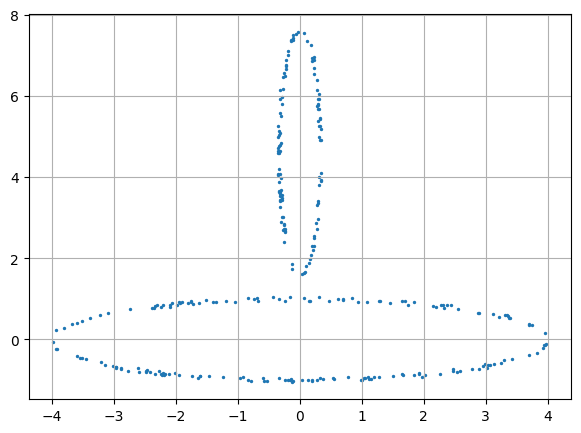

In [3]:
plt.figure(figsize=(7, 5))
a = np.array(all_data[2], dtype=np.float32)
plt.scatter(a[:, 0], a[:, 1], s=2)
plt.grid()
plt.show()

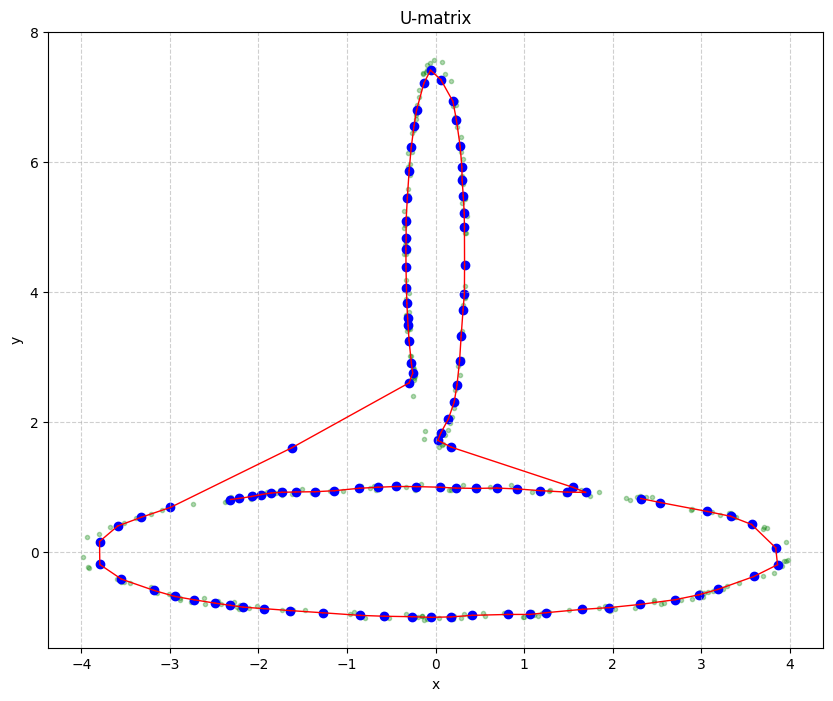

In [12]:
a = np.array(all_data[2], dtype=np.float32)

som = SelfOrganizingMap(input_size=2, map_size=(1, 100), learning_rate=0.1, sigma=2.0)

som.train(a, epochs=100)
som.plot_weights(a)

In [13]:
som.weights.shape


(1, 100, 2)